In [12]:
# !pip install hdbscan
import hdbscan

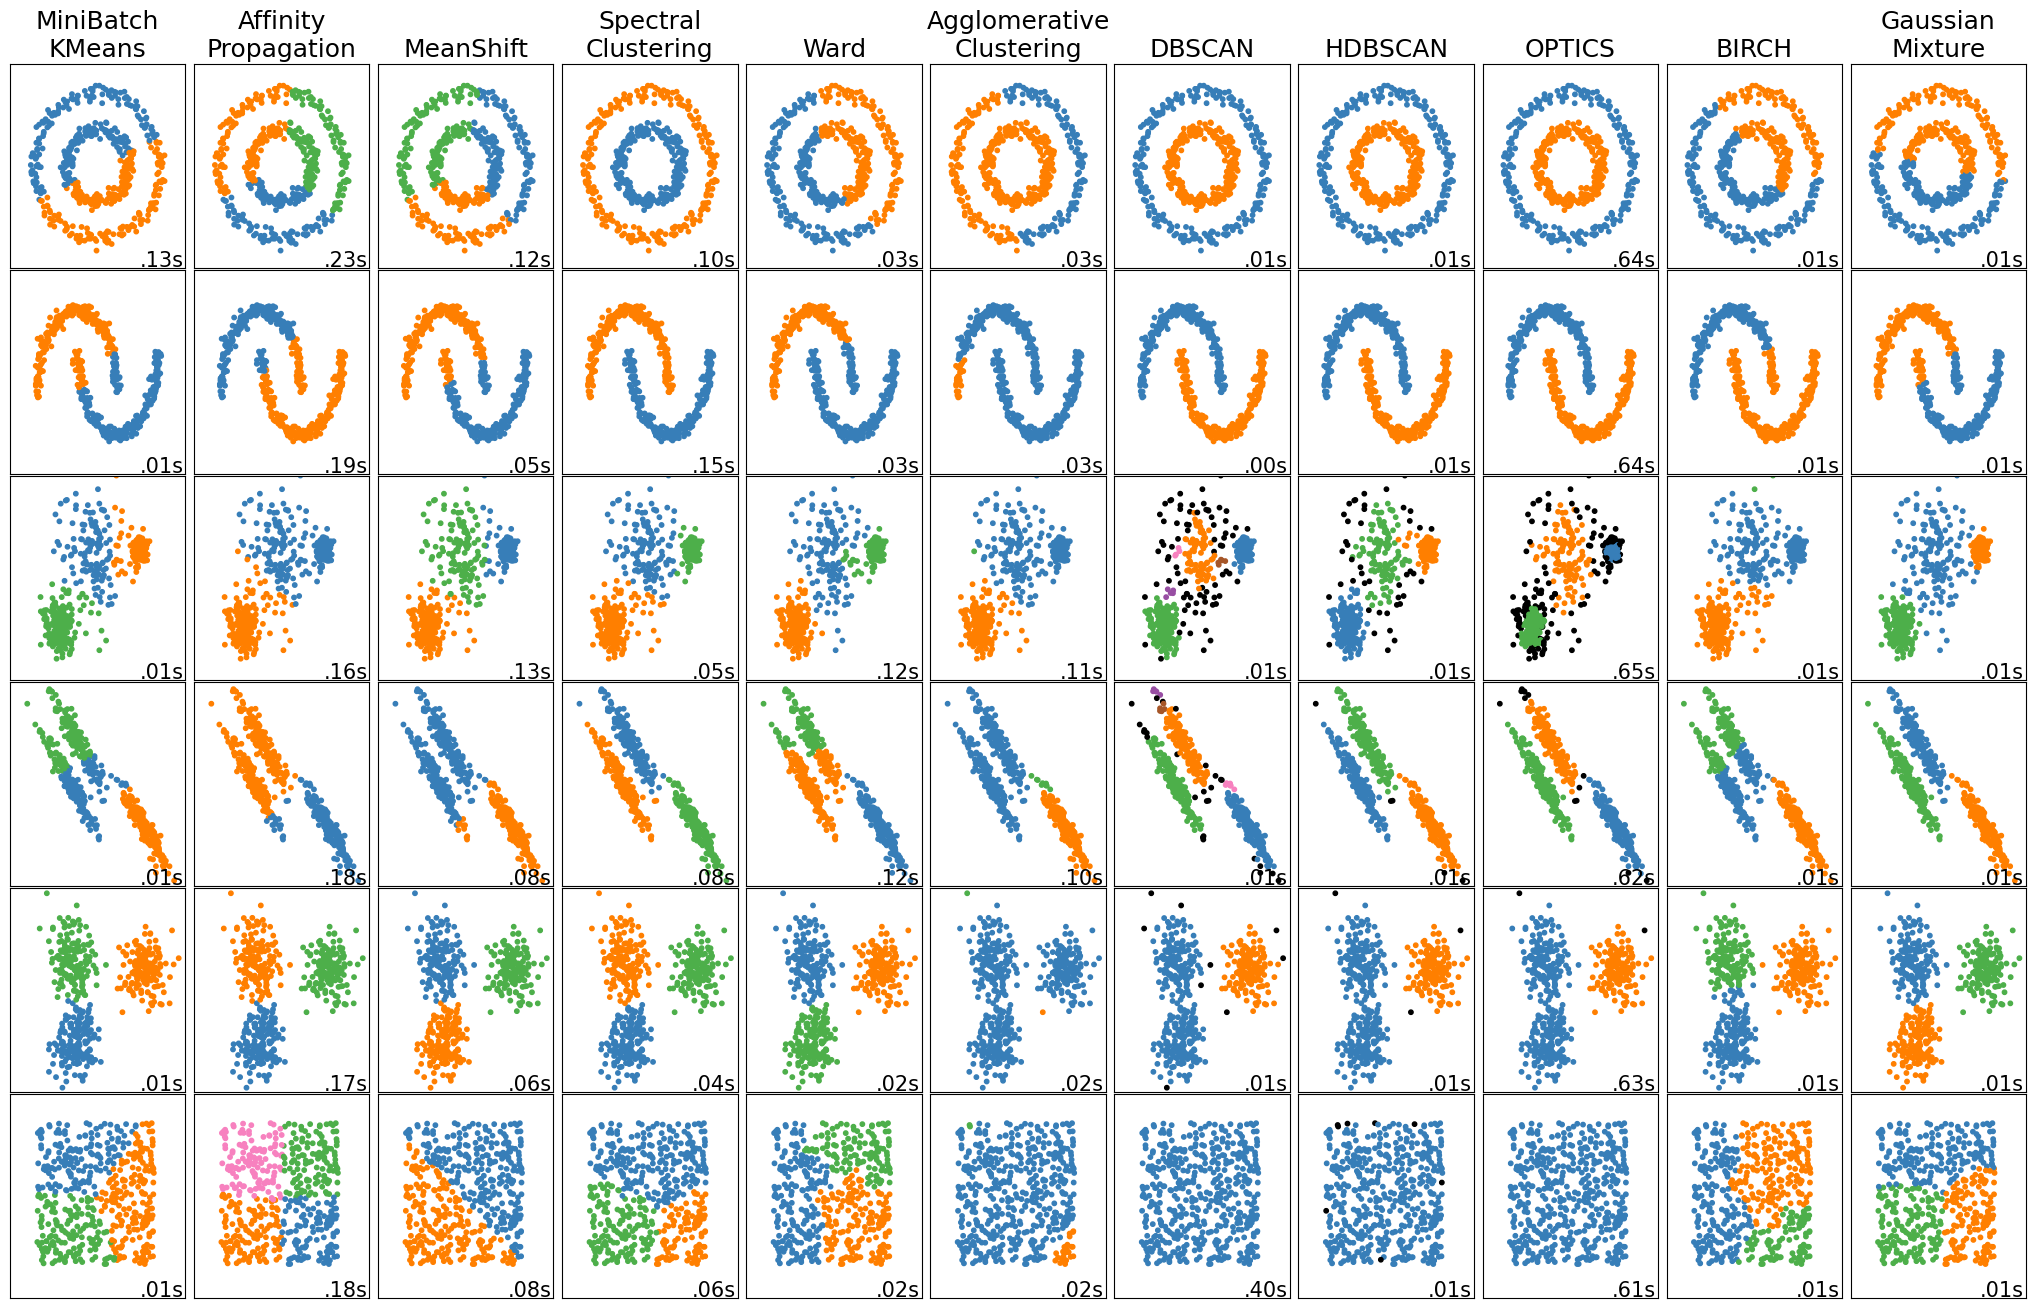

In [13]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [14]:
# !pip install --upgrade pip
# !pip uninstall -y ml_dtypes tensorflow
# !pip install tensorflow==2.12.0

Found existing installation: ml-dtypes 0.4.0
Uninstalling ml-dtypes-0.4.0:
  Successfully uninstalled ml-dtypes-0.4.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached ml_dtypes-0.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
Using cached ml_dtypes-0.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import random

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Initialize a dictionary to hold the images for each class
class_images = {i: [] for i in range(10)}

# Separate the dataset into different classes
for image, label in trainset:
    class_images[label].append(image)

# Sample 100 images randomly for each class
sampled_images = []
sampled_labels = []
for class_label in range(10):
    sampled = random.sample(class_images[class_label], 100)
    sampled_images.extend(sampled)
    sampled_labels.extend([class_label] * 100)

# Combine the sampled images and labels into a single dataset
sampled_dataset = list(zip(sampled_images, sampled_labels))

# Verify the number of images sampled for each class
sampled_counts = {i: 0 for i in range(10)}
for _, label in sampled_dataset:
    sampled_counts[label] += 1

print("Number of images sampled for each class:", sampled_counts)



Number of images sampled for each class: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


In [16]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from collections import Counter
import random

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Initialize a dictionary to hold the images for each class
class_images = {i: [] for i in range(10)}

# Separate the dataset into different classes
for image, label in trainset:
    class_images[label].append(image)

# Sample 100 images randomly for each class
sampled_images = []
sampled_labels = []
for class_label in range(10):
    sampled = random.sample(class_images[class_label], 100)
    sampled_images.extend(sampled)
    sampled_labels.extend([class_label] * 100)

# Convert images to numpy arrays and flatten them
sampled_images = torch.stack(sampled_images).numpy()
sampled_images = sampled_images.reshape(len(sampled_images), -1)
sampled_labels = np.array(sampled_labels)

# Function to match cluster labels to actual labels based on majority voting
def match_labels(true_labels, cluster_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        most_common = Counter(true_labels[mask]).most_common(1)[0][0]
        label_mapping[cluster] = most_common
    return np.array([label_mapping[cluster] for cluster in cluster_labels])

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=10)
agg_clusters = agg.fit_predict(sampled_images)
agg_labels = match_labels(sampled_labels, agg_clusters)
agg_accuracy = accuracy_score(sampled_labels, agg_labels)

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans_clusters = kmeans.fit_predict(sampled_images)
kmeans_labels = match_labels(sampled_labels, kmeans_clusters)
kmeans_accuracy = accuracy_score(sampled_labels, kmeans_labels)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=10, random_state=0)
gmm_clusters = gmm.fit_predict(sampled_images)
gmm_labels = match_labels(sampled_labels, gmm_clusters)
gmm_accuracy = accuracy_score(sampled_labels, gmm_labels)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=0)
spectral_clusters = spectral.fit_predict(sampled_images)
spectral_labels = match_labels(sampled_labels, spectral_clusters)
spectral_accuracy = accuracy_score(sampled_labels, spectral_labels)

# Print the accuracies
print("Agglomerative Clustering Accuracy:", agg_accuracy)
print("K-Means Clustering Accuracy:", kmeans_accuracy)
print("Gaussian Mixture Model Accuracy:", gmm_accuracy)
print("Spectral Clustering Accuracy:", spectral_accuracy)


Agglomerative Clustering Accuracy: 0.54
K-Means Clustering Accuracy: 0.474
Gaussian Mixture Model Accuracy: 0.474
Spectral Clustering Accuracy: 0.589


In [17]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Compute Rand Index
agg_rand_index = adjusted_rand_score(sampled_labels, agg_labels)
kmeans_rand_index = adjusted_rand_score(sampled_labels, kmeans_labels)
gmm_rand_index = adjusted_rand_score(sampled_labels, gmm_labels)
spectral_rand_index = adjusted_rand_score(sampled_labels, spectral_labels)

# Compute Mutual Information based score
agg_mutual_info = adjusted_mutual_info_score(sampled_labels, agg_labels)
kmeans_mutual_info = adjusted_mutual_info_score(sampled_labels, kmeans_labels)
gmm_mutual_info = adjusted_mutual_info_score(sampled_labels, gmm_labels)
spectral_mutual_info = adjusted_mutual_info_score(sampled_labels, spectral_labels)

# Print scores
print("Rand Index:")
print("Agglomerative Clustering:", agg_rand_index)
print("K-Means Clustering:", kmeans_rand_index)
print("Gaussian Mixture Model:", gmm_rand_index)
print("Spectral Clustering:", spectral_rand_index)

print("\nMutual Information based score:")
print("Agglomerative Clustering:", agg_mutual_info)
print("K-Means Clustering:", kmeans_mutual_info)
print("Gaussian Mixture Model:", gmm_mutual_info)
print("Spectral Clustering:", spectral_mutual_info)


Rand Index:
Agglomerative Clustering: 0.38175946455620735
K-Means Clustering: 0.29995854088200496
Gaussian Mixture Model: 0.29995854088200496
Spectral Clustering: 0.4136650624855276

Mutual Information based score:
Agglomerative Clustering: 0.5326100118738992
K-Means Clustering: 0.42499421045370506
Gaussian Mixture Model: 0.42499421045370506
Spectral Clustering: 0.575094114822129


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Get the center of each cluster
agg_cluster_centers = np.array([sampled_images[agg_labels == i].mean(axis=0) for i in range(10)])
kmeans_cluster_centers = kmeans.cluster_centers_
gmm_cluster_centers = gmm.means_
spectral_cluster_centers = np.array([sampled_images[spectral_labels == i].mean(axis=0) for i in range(10)])

# Prepare the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_images = torch.stack([image for image, _ in testset]).numpy()
test_images = test_images.reshape(len(test_images), -1)
test_labels = np.array([label for _, label in testset])

# Classify using 1-NN
def one_nn_classification(test_images, cluster_centers):
    distances = np.sqrt(((test_images[:, np.newaxis] - cluster_centers) ** 2).sum(axis=2))
    return np.argmin(distances, axis=1)

# Predict using 1-NN for each clustering method
agg_predictions = one_nn_classification(test_images, agg_cluster_centers)
kmeans_predictions = one_nn_classification(test_images, kmeans_cluster_centers)
gmm_predictions = one_nn_classification(test_images, gmm_cluster_centers)
spectral_predictions = one_nn_classification(test_images, spectral_cluster_centers)

# Calculate accuracy
agg_accuracy = accuracy_score(test_labels, agg_predictions)
kmeans_accuracy = accuracy_score(test_labels, kmeans_predictions)
gmm_accuracy = accuracy_score(test_labels, gmm_predictions)
spectral_accuracy = accuracy_score(test_labels, spectral_predictions)

print("1-NN Classifier Accuracy:")
print("Agglomerative Clustering:", agg_accuracy)
print("K-Means Clustering:", kmeans_accuracy)
print("Gaussian Mixture Model:", gmm_accuracy)
print("Spectral Clustering:", spectral_accuracy)


/tmp/ipykernel_1152241/2921869414.py:5: RuntimeWarning: Mean of empty slice.
  agg_cluster_centers = np.array([sampled_images[agg_labels == i].mean(axis=0) for i in range(10)])
/home/dgist/anaconda3/envs/3939/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  DeprecationWarning,
/tmp/ipykernel_1152241/2921869414.py:8: RuntimeWarning: Mean of empty slice.
  spectral_cluster_centers = np.array([sampled_images[spectral_labels == i].mean(axis=0) for i in range(10)])


1-NN Classifier Accuracy:
Agglomerative Clustering: 0.0974
K-Means Clustering: 0.0918
Gaussian Mixture Model: 0.0918
Spectral Clustering: 0.0892


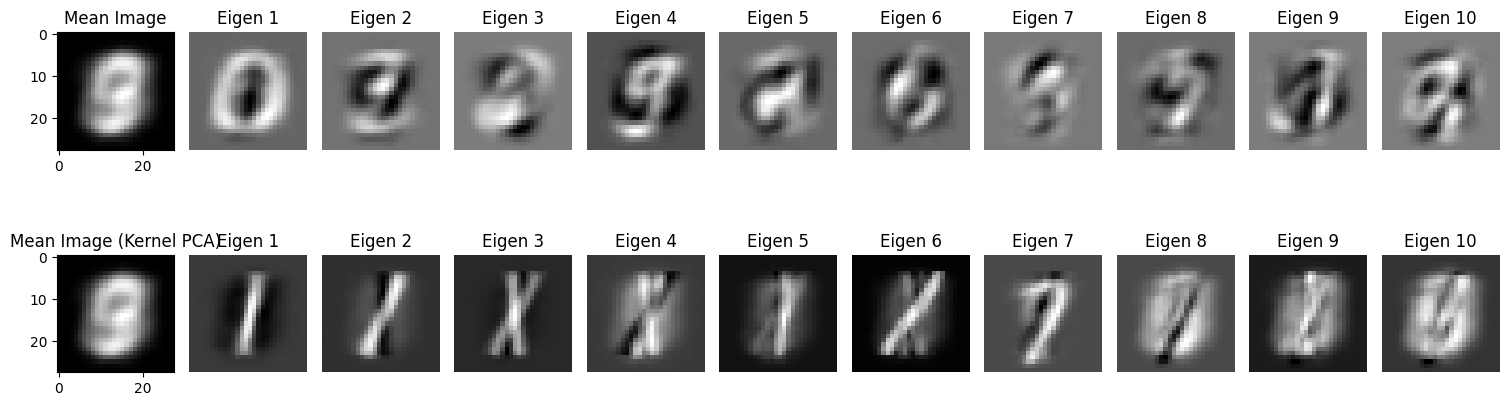

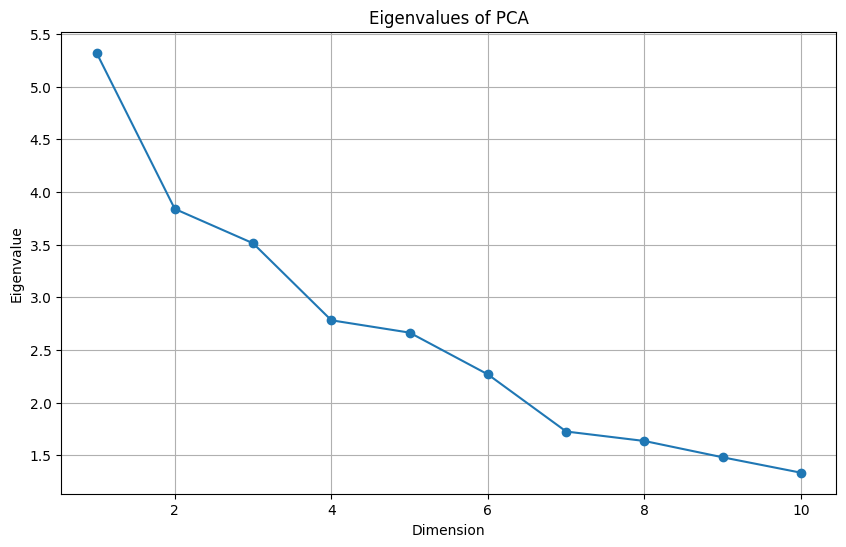

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

# Apply PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(sampled_images)

# Apply Kernel PCA
kernel_pca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1, fit_inverse_transform=True)
kernel_pca_result = kernel_pca.fit_transform(sampled_images)

# Reshape kernel_pca_result to match the shape of the fitted data
kernel_pca_result_reshaped = kernel_pca_result.reshape(sampled_images.shape[0], -1)

# Plot the mean image and the first 10 eigenvectors for PCA
fig, axes = plt.subplots(2, 11, figsize=(15, 5))
mean_image = np.mean(sampled_images, axis=0).reshape(28, 28)
axes[0, 0].imshow(mean_image, cmap='gray')
axes[0, 0].set_title("Mean Image")
for i in range(10):
    eigen_image = pca.components_[i].reshape(28, 28)
    axes[0, i+1].imshow(eigen_image, cmap='gray')
    axes[0, i+1].set_title("Eigen {}".format(i+1))
    axes[0, i+1].axis('off')

# Plot the mean image and the first 10 eigenvectors for Kernel PCA
mean_image_kernel = np.mean(kernel_pca.inverse_transform(kernel_pca_result_reshaped), axis=0).reshape(28, 28)
axes[1, 0].imshow(mean_image_kernel, cmap='gray')
axes[1, 0].set_title("Mean Image (Kernel PCA)")
for i in range(10):
    eigen_image_kernel = kernel_pca.inverse_transform(np.eye(10)[i].reshape(1, -1)).reshape(28, 28)
    axes[1, i+1].imshow(eigen_image_kernel, cmap='gray')
    axes[1, i+1].set_title("Eigen {}".format(i+1))
    axes[1, i+1].axis('off')

plt.tight_layout()
plt.show()

# Plot eigenvalues as a function of dimension for PCA
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 11), pca.explained_variance_, marker='o', linestyle='-')
plt.xlabel("Dimension")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of PCA")
plt.grid(True)
plt.show()



In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)
pca_features = pca.fit_transform(sampled_images)

# Apply Kernel PCA to reduce dimensionality
kernel_pca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1)
kernel_pca_features = kernel_pca.fit_transform(sampled_images)

# K-means clustering on PCA-reduced features
kmeans_pca = KMeans(n_clusters=10, random_state=0)
kmeans_pca_clusters = kmeans_pca.fit_predict(pca_features)

# K-means clustering on Kernel PCA-reduced features
kmeans_kernel_pca = KMeans(n_clusters=10, random_state=0)
kmeans_kernel_pca_clusters = kmeans_kernel_pca.fit_predict(kernel_pca_features)

# Compute Rand Index and Mutual Information based score for PCA
pca_rand_index = adjusted_rand_score(sampled_labels, kmeans_pca_clusters)
pca_mutual_info = adjusted_mutual_info_score(sampled_labels, kmeans_pca_clusters)

# Compute Rand Index and Mutual Information based score for Kernel PCA
kernel_pca_rand_index = adjusted_rand_score(sampled_labels, kmeans_kernel_pca_clusters)
kernel_pca_mutual_info = adjusted_mutual_info_score(sampled_labels, kmeans_kernel_pca_clusters)

# Print scores
print("K-means Clustering Results:")
print("PCA - Rand Index:", pca_rand_index)
print("PCA - Mutual Information:", pca_mutual_info)
print("Kernel PCA - Rand Index:", kernel_pca_rand_index)
print("Kernel PCA - Mutual Information:", kernel_pca_mutual_info)


K-means Clustering Results:
PCA - Rand Index: 0.30968699299865066
PCA - Mutual Information: 0.45005478638725394
Kernel PCA - Rand Index: 0.02086253765350899
Kernel PCA - Mutual Information: 0.16879361858582115


Accuracy of 1-NN classifier: 0.8772
Class: 0
Correctly classified:


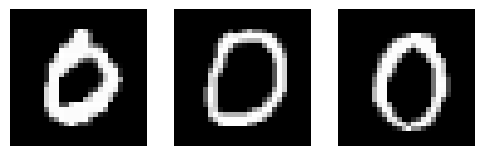

Incorrectly classified:


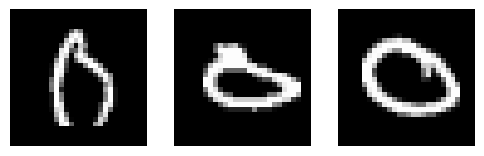

Class: 1
Correctly classified:


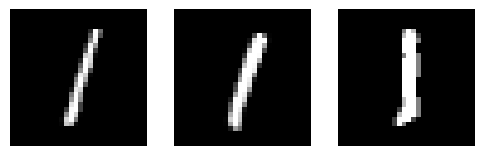

Incorrectly classified:


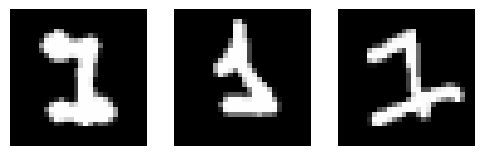

Class: 2
Correctly classified:


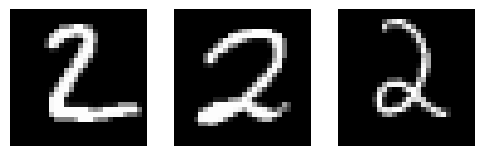

Incorrectly classified:


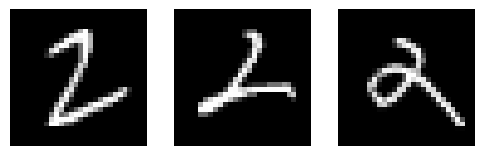

Class: 3
Correctly classified:


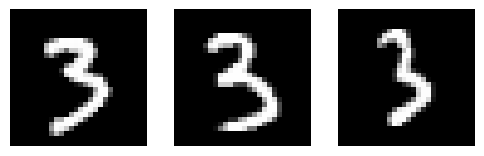

Incorrectly classified:


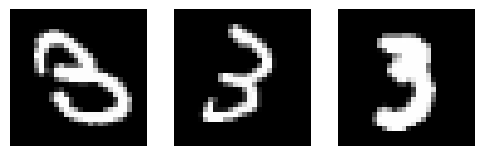

Class: 4
Correctly classified:


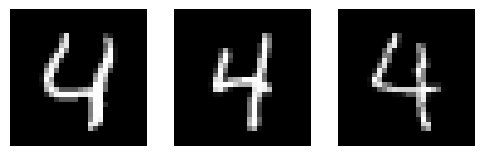

Incorrectly classified:


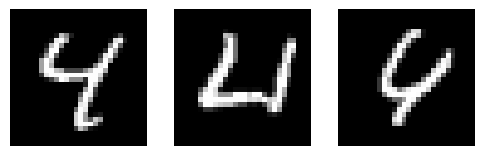

Class: 5
Correctly classified:


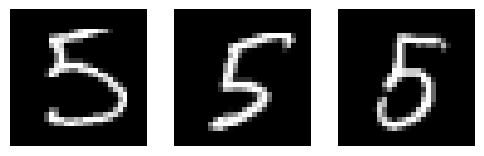

Incorrectly classified:


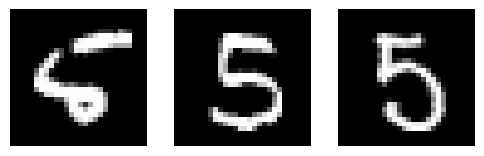

Class: 6
Correctly classified:


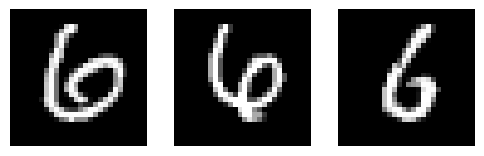

Incorrectly classified:


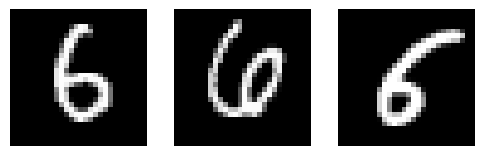

Class: 7
Correctly classified:


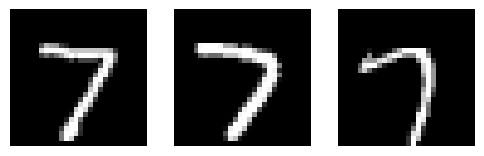

Incorrectly classified:


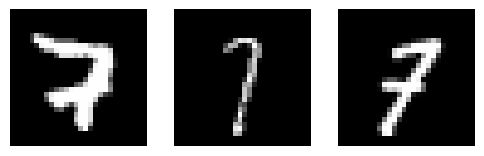

Class: 8
Correctly classified:


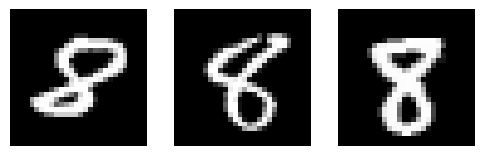

Incorrectly classified:


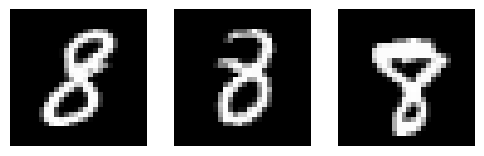

Class: 9
Correctly classified:


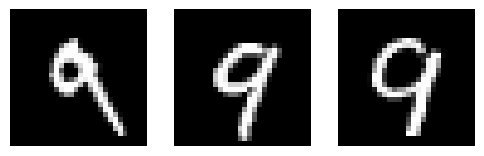

Incorrectly classified:


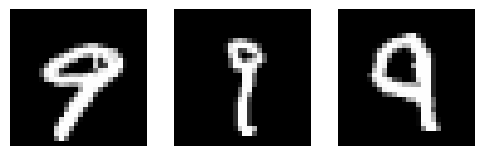

In [20]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, KernelPCA

# Train 1-NN classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(sampled_images, sampled_labels)

# Classify test data
test_predictions = knn.predict(test_images)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy of 1-NN classifier:", accuracy)

# Visualize correctly and incorrectly classified images
def visualize_images(true_labels, predicted_labels, images, num_samples=3):
    for label in range(10):
        correct_indices = np.where((true_labels == label) & (predicted_labels == label))[0][:num_samples]
        incorrect_indices = np.where((true_labels == label) & (predicted_labels != label))[0][:num_samples]

        print("Class:", label)
        print("Correctly classified:")
        plt.figure(figsize=(num_samples*2, 2))
        for i, idx in enumerate(correct_indices):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

        print("Incorrectly classified:")
        plt.figure(figsize=(num_samples*2, 2))
        for i, idx in enumerate(incorrect_indices):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

# Visualize correctly and incorrectly classified images for each class
visualize_images(test_labels, test_predictions, test_images)

